In [1]:
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import numpy as np



In [2]:
dataset_df = pd.read_csv('dataset.csv').to_numpy()
sounds_dataset = dataset_df[:, 0]
sr = 0
for i in range(len(sounds_dataset)):
    sounds_dataset[i], sr = librosa.load(f'Noisy-sounds/{sounds_dataset[i]}.wav')

label_dataset = dataset_df[:, 1]
for i in range(len(label_dataset)):
    label_dataset[i], sr = librosa.load(f'Clean-sounds/{label_dataset[i]}.wav')

X_train, X_test, y_train, y_test = train_test_split(sounds_dataset, label_dataset, test_size=0.1, random_state=42)



In [3]:
def to_spectogram(sound):
    stft = librosa.stft(sound.astype(np.float64), n_fft = 64, hop_length=32)
    stft = np.abs(stft)
    db = librosa.amplitude_to_db(stft, ref=np.max)
    return db
    # print(db)
    # librosa.display.specshow(db, y_axis='log', x_axis='time')


In [4]:
spectogram_train = []
for x in X_train:
    spectogram_train.append(to_spectogram(x))
spectogram_label = []
for x in y_train:
    spectogram_label.append(to_spectogram(x))
spectogram_val = []
for x in X_test:
    spectogram_val.append(to_spectogram(x))
spectogram_val_label = []
for x in y_test:
    spectogram_val_label.append(to_spectogram(x))



KeyboardInterrupt: 

In [57]:
max_len = 0
for x in spectogram_train:
    max_len = max(max_len, len(x[0]))
for x in spectogram_label:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val_label:
    max_len = max(max_len, len(x[0]))
print(max_len)
print(len(spectogram_train[0]))

3449
33


In [58]:
def pad_vector(vec):
    for i in range(len(vec)):
        vec[i] = np.pad(vec[i], ((0, 0), (0, max_len - len(vec[i][0]))))
    return vec

In [ ]:
def remove_extra(vec):
    for i in range(len(vec)):
        vec[i] = vec[i][:-1]
    vec = vec[:-1]
    return vec

In [60]:
spectogram_train = pad_vector(spectogram_train)
spectogram_label = pad_vector(spectogram_label)
spectogram_val = pad_vector(spectogram_val)
spectogram_val_label = pad_vector(spectogram_val_label)

spectogram_train = remove_extra(spectogram_train)
spectogram_label = remove_extra(spectogram_label)
spectogram_val = remove_extra(spectogram_val)
spectogram_val_label = remove_extra(spectogram_val_label)


In [8]:
spectogram_train = np.array(spectogram_train)
spectogram_label = np.array(spectogram_label)
spectogram_val = np.array(spectogram_val)
spectogram_val_label = np.array(spectogram_val_label)

In [9]:
spectogram_train = spectogram_train / -80
spectogram_label = spectogram_label / -80
spectogram_val = spectogram_val / -80
spectogram_val_label = spectogram_val_label / -80

In [10]:
print(spectogram_train.shape)

(5675, 129, 863)


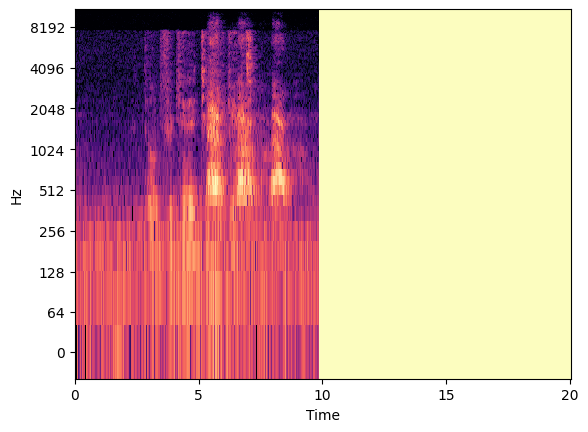

In [11]:
test = spectogram_train[0] * -80
librosa.display.specshow(test, y_axis='log', x_axis='time')

In [13]:
print(np.min(spectogram_train[0]), np.max(spectogram_train[0]))

-0.0 1.0


In [51]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow import keras
# Define the dimensions of the input data
input_shape = (128, 864, 1)  # MNIST dataset has 28x28 grayscale images

inputs = tf.keras.Input(shape=input_shape)
size_filter_in = 16
kernel_init = 'he_normal'
activation_layer = None
# Encoder
conv1 = keras.layers.Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
conv1 = keras.layers.LeakyReLU()(conv1)
conv1 = keras.layers.Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
conv1 = keras.layers.LeakyReLU()(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
conv2 = keras.layers.LeakyReLU()(conv2)
conv2 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
conv2 = keras.layers.LeakyReLU()(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
conv3 = keras.layers.LeakyReLU()(conv3)
conv3 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
conv3 = keras.layers.LeakyReLU()(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
conv4 = keras.layers.LeakyReLU()(conv4)
conv4 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
conv4 = keras.layers.LeakyReLU()(conv4)
drop4 = keras.layers.Dropout(0.5)(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = keras.layers.Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
conv5 = keras.layers.LeakyReLU()(conv5)
conv5 = keras.layers.Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
conv5 = keras.layers.LeakyReLU()(conv5)
drop5 = keras.layers.Dropout(0.5)(conv5)

up6 = keras.layers.Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
up6 = keras.layers.LeakyReLU()(up6)
merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
conv6 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
conv6 = keras.layers.LeakyReLU()(conv6)
conv6 = keras.layers.Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
conv6 = keras.layers.LeakyReLU()(conv6)
up7 = keras.layers.Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
up7 = keras.layers.LeakyReLU()(up7)
merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
conv7 = keras.layers.LeakyReLU()(conv7)
conv7 = keras.layers.Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
conv7 = keras.layers.LeakyReLU()(conv7)
up8 = keras.layers.Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
up8 = keras.layers.LeakyReLU()(up8)
merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
conv8 = keras.layers.LeakyReLU()(conv8)
conv8 = keras.layers.Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
conv8 = keras.layers.LeakyReLU()(conv8)

up9 = keras.layers.Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
up9 = keras.layers.LeakyReLU()(up9)
merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = keras.layers.Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
conv9 = keras.layers.LeakyReLU()(conv9)
conv9 = keras.layers.Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
conv9 = keras.layers.LeakyReLU()(conv9)
conv9 = keras.layers.Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
conv9 = keras.layers.LeakyReLU()(conv9)
conv10 = keras.layers.Conv2D(1, 1, activation = 'tanh')(conv9)



model = Model(inputs=inputs, outputs=conv10)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 128, 864, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_340 (Conv2D)            (None, 128, 864, 16  160         ['input_33[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_91 (LeakyReLU)     (None, 128, 864, 16  0           ['conv2d_340[0][0]']             
                                )                                                          

In [45]:
history = model.fit(spectogram_train, spectogram_label,
                epochs=5,
                batch_size=64,
                shuffle=True,
                validation_data=(spectogram_val, spectogram_val_label),)

Epoch 1/5
  5/355 [..............................] - ETA: 1:45:50 - loss: 0.1353 - mae: 0.3352

KeyboardInterrupt: 

In [27]:
sample, sr = librosa.load('Noisy-sounds/Sound1.wav')
sample = to_spectogram(sample)
sample = np.array(sample)
sample = np.pad(sample, ((0, 0), (0, max_len - len(sample[0]))))
sample = np.expand_dims(sample, axis=0)
sample = sample / -80

In [28]:
prediction = model.predict(sample)
print(prediction.shape)
print(np.min(prediction))

1/1 [==============================] - 0s 368ms/step
(1, 129, 863)
-0.23174766


(110336,)


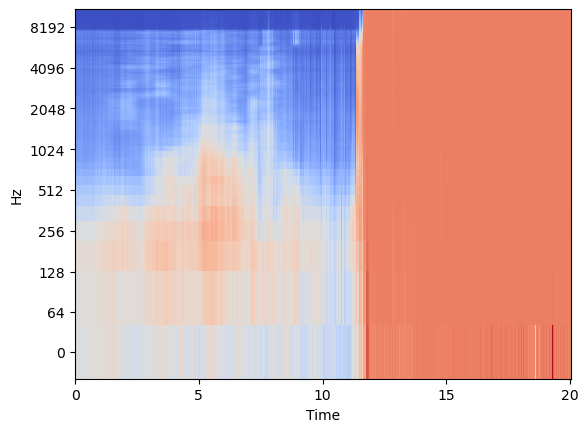

In [29]:
import soundfile as sf
#prediction = librosa.db_to_amplitude(prediction)
prediction = np.squeeze(prediction)
prediction = prediction * -80
librosa.display.specshow(prediction, y_axis='log', x_axis='time')
prediction = librosa.istft(prediction, hop_length=128, n_fft=256)
print(prediction.shape)


In [ ]:
print(np.max(prediction))

In [ ]:
target, sr = librosa.load('Clean-sounds/1087_MTI_DIS_XX.wav')
target = to_spectogram(target)
librosa.display.specshow(target, y_axis='log', x_axis='time')

In [30]:
sf.write('test_denoised.wav', prediction, sr)